# 서울시 지역별 생활쓰레기 배출량 예측 및 해결방안

## 1. 데이터 전처리

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
# 폰트설정
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# 모듈 불러오기
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor, VotingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from tensorflow.keras.optimizers import Adam # 옵티마이저 설정을 위해서

In [105]:
def del_unname_col(path):
    df = pd.read_csv(path)
    list1 = list(df.columns)
    if 'Unnamed: 0' in list1:
        df.drop('Unnamed: 0', inplace=True, axis = 1)
    return df

In [106]:
path = 'final.csv'
data = del_unname_col(path)
data.head()

,자치구,시점,단독주택,아파트,연립주택,다세대주택,비거주용건물내,1인가구,2인가구,3인가구,...,65~69세,70~74세,75~79세,80~84세,85세이상,발생량,재활용,소각,매립,기타
0,종로구,2017,12920,14507,5451,11978,931,23638,15697,11268,...,1151,1065,998,608,430,375.1,227.70,109.60,37.8,0.0
1,종로구,2018,12699,14530,5428,12140,932,25326,15957,11241,...,1113,1111,1014,674,444,362.7,234.70,86.10,41.9,0.0
2,종로구,2019,12421,15290,5459,12349,921,24671,16208,11154,...,1201,1120,1047,704,470,339.9,219.60,79.90,40.3,0.1
3,종로구,2020,12259,15688,5460,12540,912,25983,16281,10882,...,1337,1156,1108,749,547,264.2,153.50,83.40,25.9,1.4
4,종로구,2021,11987,15775,5490,12725,908,27308,16320,10690,...,1546,1160,1133,811,597,355.1,189.45,133.25,31.7,0.7


 3 )  x, y 분리

In [107]:
# target 확인
target = '발생량'

# 데이터 분리
x = data.drop(target, axis = 1)
y = data[target]
norm_cols = list(x.columns)

 4 ) 가변수화

In [108]:
# 가변수화 열 지정
dumm_cols = ['자치구', '시점']

# 가변수화
x = pd.get_dummies(x, columns = dumm_cols, drop_first=True)

# 확인
x.head()

,단독주택,아파트,연립주택,다세대주택,비거주용건물내,1인가구,2인가구,3인가구,4인가구,5인가구,...,자치구_영등포구,자치구_용산구,자치구_은평구,자치구_종로구,자치구_중구,자치구_중랑구,시점_2018,시점_2019,시점_2020,시점_2021
0,12920,14507,5451,11978,931,23638,15697,11268,8636,2351,...,0,0,0,1,0,0,0,0,0,0
1,12699,14530,5428,12140,932,25326,15957,11241,8286,2228,...,0,0,0,1,0,0,1,0,0,0
2,12421,15290,5459,12349,921,24671,16208,11154,7828,2143,...,0,0,0,1,0,0,0,1,0,0
3,12259,15688,5460,12540,912,25983,16281,10882,7679,2027,...,0,0,0,1,0,0,0,0,1,0
4,11987,15775,5490,12725,908,27308,16320,10690,7367,1826,...,0,0,0,1,0,0,0,0,0,1


In [109]:
for i in dumm_cols:
    norm_cols.remove(i)


In [110]:
# 정규화
for i in norm_cols:
    x[i] = (x[i] - x[i].min()) / (x[i].max() - x[i].min())

In [111]:
x.head()

,단독주택,아파트,연립주택,다세대주택,비거주용건물내,1인가구,2인가구,3인가구,4인가구,5인가구,...,자치구_영등포구,자치구_용산구,자치구_은평구,자치구_종로구,자치구_중구,자치구_중랑구,시점_2018,시점_2019,시점_2020,시점_2021
0,0.377229,0.000000,0.659844,0.085982,0.469898,0.029925,0.037703,0.043694,0.068726,0.112788,...,0,0,0,1,0,0,0,0,0,0
1,0.366251,0.000153,0.656016,0.088520,0.470408,0.044465,0.042429,0.043139,0.060659,0.099810,...,0,0,0,1,0,0,1,0,0,0
2,0.352442,0.005217,0.661175,0.091795,0.464796,0.038823,0.046992,0.041352,0.050104,0.090842,...,0,0,0,1,0,0,0,1,0,0
3,0.344394,0.007869,0.661341,0.094788,0.460204,0.050124,0.048319,0.035764,0.046670,0.078603,...,0,0,0,1,0,0,0,0,1,0
4,0.330883,0.008449,0.666334,0.097687,0.458163,0.061538,0.049028,0.031820,0.039479,0.057396,...,0,0,0,1,0,0,0,0,0,1


In [112]:

# 데이터 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)  

In [113]:
nfeatures = x_train.shape[1]
clear_session()

# Sequential 모델
def model_fn():
    model = Sequential([Dense(32, input_shape = (nfeatures,), activation = 'relu'),
                        Dense(16, activation = 'relu'), 
                        Dense(8, activation = 'relu'),
                        Dense(4, activation = 'relu'),
                        Dense(1, activation = 'relu')])
    return model

- 딥러닝 cv_score 출력을 위한 실험적 코드

In [114]:
from sklearn.model_selection import KFold
k=5
 
kfold = KFold(n_splits=k, shuffle=True)
 
 
#Accuracy(정확도)를 정리할 빈 리스트 만들기
acc_score = []
k=5
 
kfold = KFold(n_splits=k, shuffle=True)
 
 
#Accuracy(정확도)를 정리할 빈 리스트 만들기
acc_score = []
for train_index, test_index in kfold.split(x):
      x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)
      model = model_fn()
      model.compile(optimizer= 'adam' , loss  = 'mse',  metrics=['accuracy'])
      history = model.fit(x_train, y_train, epochs=100, batch_size=10, verbose=0)
      accuracy = model.evaluate(x_test, y_test)[1]
      acc_score.append(accuracy)

38/38 [==============================] - 0s 1ms/step


In [115]:
print('정확도:',acc_score)
print('정확도 평균', np.mean(acc_score))

정확도: [0.0, 0.0, 0.0, 0.0, 0.0]
정확도 평균 0.0


In [116]:
acc_score = []
for train_index, test_index in kfold.split(x):
    x_train, x_test = x.iloc[train_index,:], x.iloc[test_index,:]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    model = model_fn()
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=100, batch_size=36, verbose=0)
    accuracy = model.evaluate(x_test, y_test)[1]
    acc_score.append(accuracy)

25/25 [==============================] - 0s 4ms/step


In [117]:
result = {}

avg_acc_score = sum(acc_score) / k
result['DL'] = np.mean(acc_score)
print('정확도:',acc_score)
print('정확도 평균', np.mean(acc_score))

정확도: [0.0, 0.0, 0.0, 0.0, 0.0]
정확도 평균 0.0


**1) KNN**

In [118]:
# 선언하기
model_knn = KNeighborsRegressor()

# 성능예측
cv_score = cross_val_score(model_knn, x_train, y_train, cv = 10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집

# 결과 확인
result['KNN'] = cv_score.mean()


[-1.44782085 -1.42395199 -2.33169584 -0.53899024 -0.43163577  0.64549722
  0.26870064  0.12593587  0.17919176  0.50019223]
-0.4454576973390851


**2) Decision Tree**

In [119]:
# 선언하기
model_dt = DecisionTreeRegressor()

# 성능예측
cv_score = cross_val_score(model_dt, x_train, y_train, cv = 10, scoring='r2' )

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['DecisionTree'] = cv_score.mean()

[0.31045815 0.42608027 0.78978001 0.63453285 0.55124854 0.75520124
 0.81068542 0.76476491 0.90083611 0.30011477]
0.6243702268332685


**3) Linear Regression**

In [120]:
# 선언하기
model_lgr = LinearRegression()

# 성능예측
cv_score = cross_val_score(model_lgr, x_train, y_train, cv=10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['Linear'] = cv_score.mean()

[0.99877745 0.99570155 0.9998956  0.99980132 0.99980879 0.99999433
 0.99983306 0.99959518 0.99999389 0.9999966 ]
0.9993397771839694


**4) Random Forest**

In [121]:
# 선언하기
model_rf = RandomForestRegressor()

# 성능예측
cv_score = cross_val_score(model_rf, x_train, y_train, cv=10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['Random Forest'] = cv_score.mean()

[0.11954703 0.59194336 0.81944139 0.75132787 0.48600442 0.81612533
 0.91403613 0.63754546 0.92427921 0.78971643]
0.6849966622716794


**5) XGBoost**

In [122]:
# 선언하기
model_xgb = XGBRegressor()

# 성능예측
cv_score = cross_val_score(model_xgb, x_train, y_train, cv = 10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['XGBoost'] = cv_score.mean()


[-0.10379726  0.70610656  0.82294245  0.71930835  0.6642405   0.94699853
  0.91341545  0.74862633  0.92673608  0.92329227]
0.7267869270184508


**6) LightGBM**

In [123]:
# 선언하기
model_lgbm = LGBMRegressor()

# 성능예측
cv_score = cross_val_score(model_lgbm, x_train, y_train, cv = 10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['LighGBM'] = cv_score.mean()

[0.41589154 0.1880494  0.19229488 0.79204093 0.06414751 0.8251746
 0.34747908 0.24954189 0.78734201 0.49847844]
0.43604402654844093


7)Stacking ensemble

In [134]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import *

# 선언하기
estimators = [('dt', DecisionTreeRegressor()),
              ('knn', make_pipeline(MinMaxScaler(), KNeighborsRegressor())),
              ('lr', LinearRegression()),
              ('XGB', XGBRegressor())]

model = StackingRegressor(estimators=estimators,
                           final_estimator= RandomForestRegressor())

# 학습하기
model.fit(x_train, y_train)


# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv = 10, scoring='r2')

# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['Stacking'] = cv_score.mean()

[0.98951927 0.98297362 0.9936127  0.97290341 0.91131927 0.99734946
 0.94753911 0.99914313 0.991369   0.92055859]
0.9706287560569479


8) voting

In [137]:
# 선언하기
estimators = [('lr', LinearRegression()),
              ('dt', DecisionTreeRegressor()),
              ('knn', make_pipeline(MinMaxScaler(), KNeighborsRegressor())),
              ('XGB', XGBRegressor())]

model = VotingRegressor(estimators=estimators)

# 학습하기
model.fit(x_train, y_train)


# 성능예측
cv_score = cross_val_score(model, x_train, y_train, cv = 10, scoring='r2')
# 결과확인
print(cv_score)
print(cv_score.mean())

# 결과수집
result['Voting'] = cv_score.mean()

[0.29293397 0.68817145 0.75300257 0.66897269 0.88149458 0.93015409
 0.96906177 0.82408087 0.91677187 0.87680449]
0.7801448347004476



#### 6. 결과 확인

In [138]:
# 성능 비교
result = dict(sorted(result.items(), key=lambda x:x[1], reverse=True))
print('=' * 40)
for m_name, score in result.items():
    print(m_name, score.round(3))
print('=' * 40)

Linear 0.999
Stacking 0.971
Voting 0.78
XGBoost 0.727
Random Forest 0.685
DecisionTree 0.624
LighGBM 0.436
DL 0.0
KNN -0.445


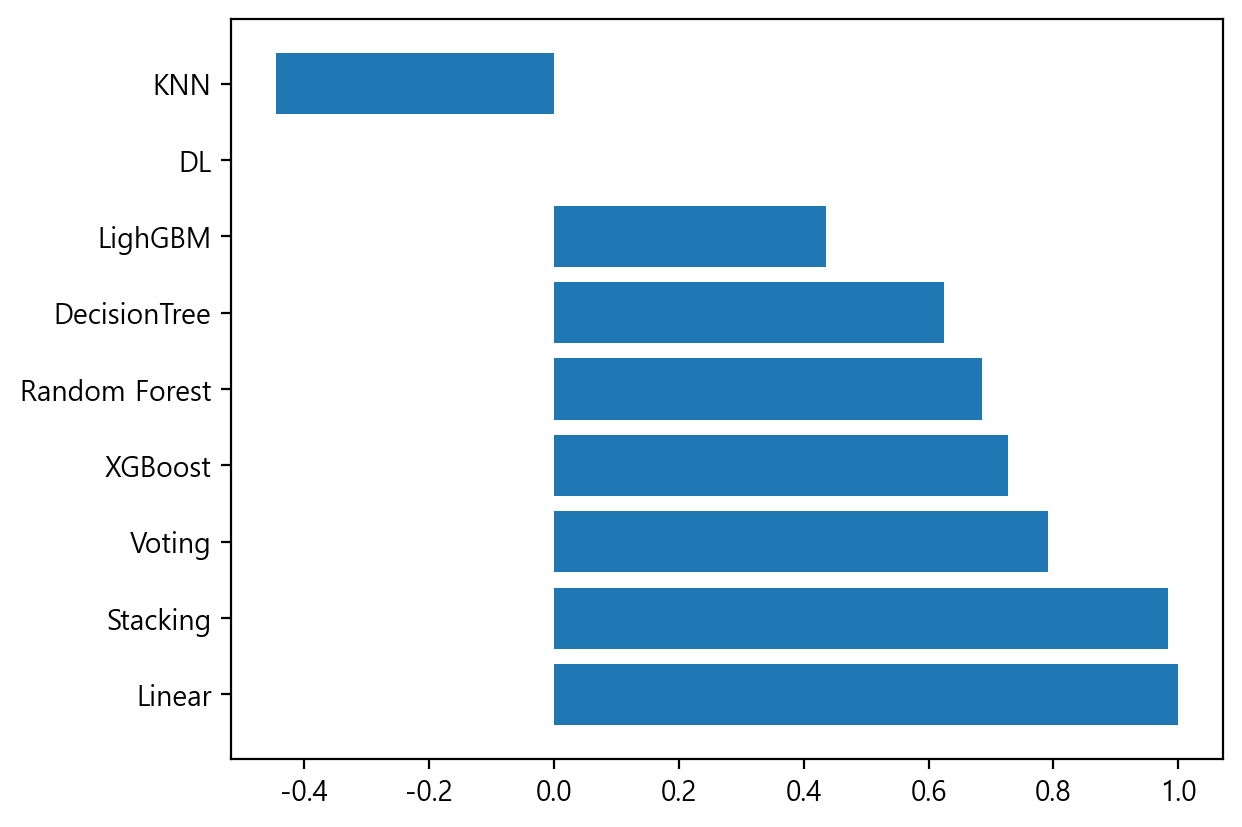

In [127]:
# 성능 시각화 비교
plt.barh(list(result.keys()), result.values())
plt.show()

#### 7. 성능 튜닝

In [150]:
# 기본 모델 선언
model_rf = RandomForestRegressor()
 
# 파라미터 지정
param = {'max_depth': range(1, 21)}
 
# 모델 선언
model = GridSearchCV(model_rf,param, cv = 10,scoring='r2')
 
model.fit(x_train, y_train)


GridSearchCV(cv=10, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [148]:
# 학습하기
model.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 21)}, scoring='r2')

In [151]:
# 최적 파라미터, 예측 최고 성능
print(model.best_params_)
print(model.best_score_)

{'max_depth': 17}
0.7001276558298516


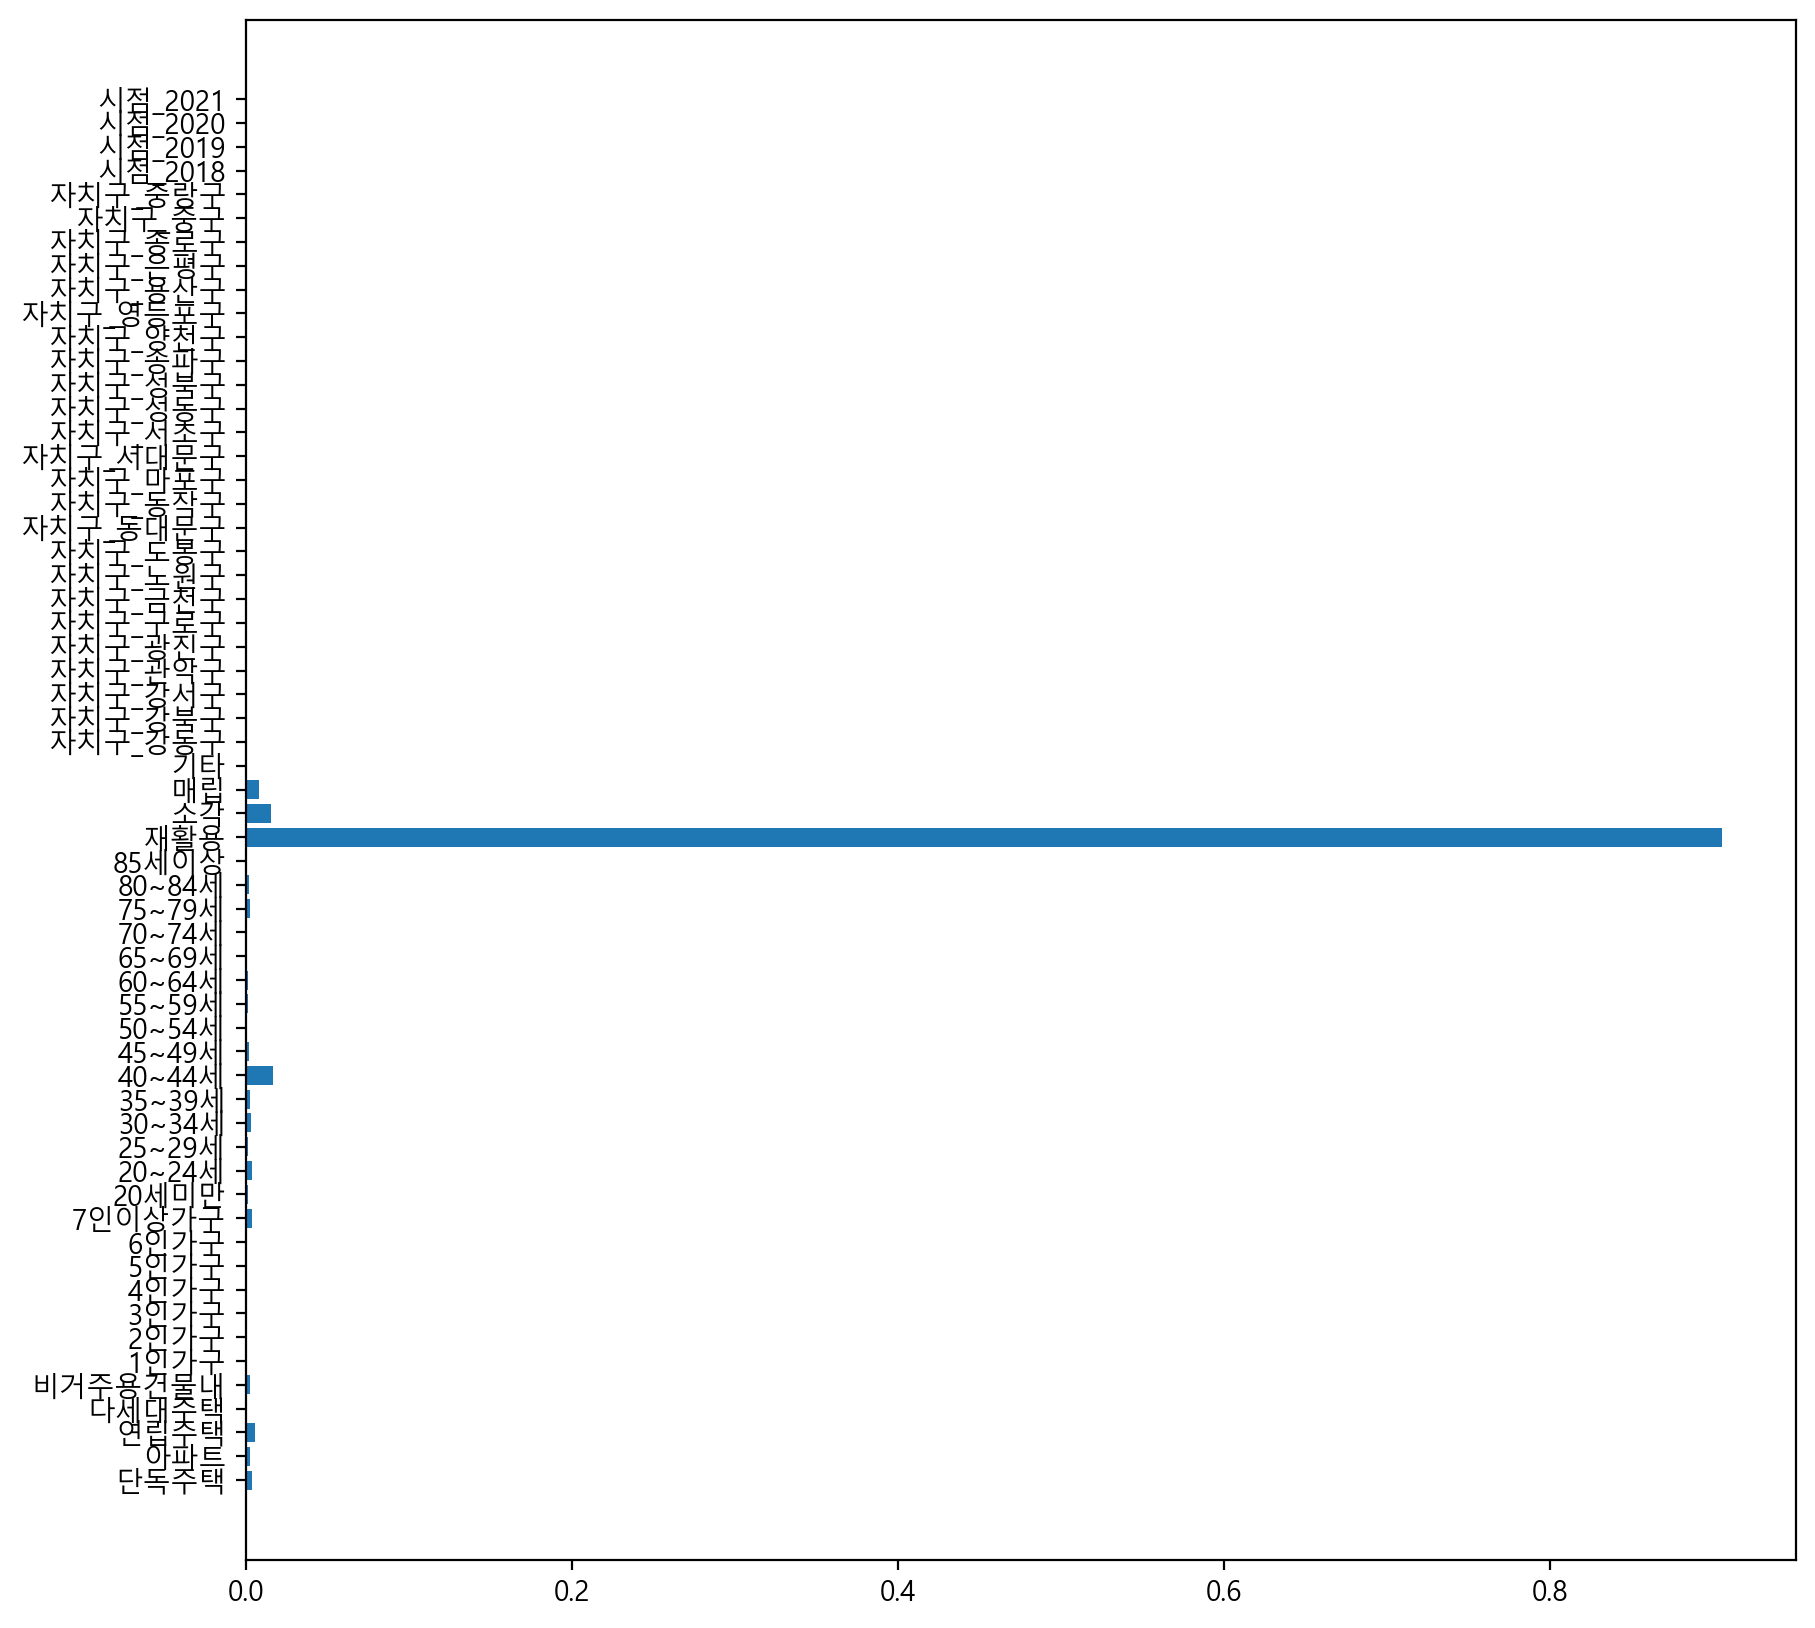

In [153]:
# 변수 중요도 시각화
plt.figure(figsize=(10,10))
plt.barh(list(x), model.best_estimator_.feature_importances_)
plt.show()


#### 8. 성능 평가

In [154]:
# 예측하기
y_pred = model.predict(x_test)

In [156]:
# 성능평가
print(mean_absolute_error(y_test, y_pred))
print(r2_score(y_test, y_pred))

23.679539999999992
0.9110636676989232
